In [245]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 
from numba import jit

from sklearn import linear_model
import sklearn.linear_model as skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [258]:
sig2 = 1

# Define the Franke Fumction
def frankeFunction(x,y,sig2):
    noise = np.random.normal(0,sig2,len(x))
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints():
    x = np.arange(0, 1, 0.1)
    y = np.arange(0, 1, 0.1)
    x_d, y_d = np.meshgrid(x,y)
    z_d = frankeFunction(x_d,y_d,sig2)
    return x_d, y_d, z_d

# Create the design matrix with all possible combinations
@jit
def createDesignMatrix(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x**(i-j))*(y**j)
    return X

# Predict the outcome using matrix inversion
def predict(X, z_data):
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_data)
    ztilde = X @ beta
    return ztilde, beta

# Calculate the mean square error (MSE)
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(z_data, z_model):
    n = np.size(z_data)
    return 1 - np.sum((z_data-z_model)**2)/np.sum((z_data-(np.sum(z_data)/n))**2)

#Scale the data and split them for training and testing
def splitAndScale(x,z):
    X_train, X_test, z_train, z_test = train_test_split(x,z,test_size=0.3)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train, X_test, z_train, z_test

# Calculate the confidence interval of parameters Beta's
def CIBeta(X, Beta):
    varBeta = np.diagonal(np.linalg.inv(X.T @ X)*sig2)
    stdBeta = np.sqrt(varBeta)
    CIlow = Beta - 1.645*stdBeta
    CIhigh = Beta + 1.645*stdBeta
    return CIlow, CIhigh

# I cannot get this function to work with X_train
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    print(A.shape)
    print(U.shape)
    print(s.shape)
    print(VT.shape)
    S = np.diag(s)
    UT = np.transpose(U)
    V = np.transpose(VT)
    invS = np.linalg.inv(S)
    #print(np.matmul(V,np.matmul(invD,UT)).shape)
    return np.matmul(V,np.matmul(invS,UT))

def kfoldCV(x,y,z,k=5):
    # The general procedure is as follows:
    # 1. Shuffle the dataset randomly.
    # 2. Split the dataset into k groups
    # 3. For each unique group:
    #    1. Take the group as a hold out or test data set
    #    2. Take the remaining groups as a training data set
    #    3. Fit a model on the training set and evaluate it on the test set
    #    4. Retain the evaluation score and discard the model
    # 4. Summarize the skill of the model using the sample of model evaluation scores
    
    #Concatenate the data points
    #data = np.concatenate((x,y),axis=0)
    
    #HOW TO COMBINE X AND Y IN THE RIGHT FORMAT?
    #First, split data into test and training set
    x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.3)
    
    data = np.concatenate((x_train, y_train), axis=1)
    
    #Randomly shuffle the data
    np.random.shuffle(data)
    
    #Split data set into k parts
    splitData = np.array_split(data,k)
    
    for i in range(0,k):
        train = np.zeros((0,3)) #reset train set for each kth run
        for j in range(0,k):
            if j==i:
                test = splitData[j]
                continue
            train = np.concatenate((train, splitData[j]), axis=0)
        
        X_design = createDesignMatrix(train[:,0], train[:,1])
    

def ridgeRegression(X_train,X_test,z_train,n):   
    N = np.size(X_train,1)
    I = np.eye(N)
    
    # Decide which value of lambda to use
    nlambdas = 4
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Ridge
        clf_ridge = skl.Ridge(alpha=lmb).fit(X_train,z_train)
        beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb*I) @ X_train.T @ z_train
        # Make predictions
        z_tilde = X_train @ beta_ridge
        z_predict = X_test @ beta_ridge
        z_ridgeSKL = clf_ridge.predict(X_test)
        MSEPredict[i] = MSE(z_test, z_predict)
        MSETrain[i] = MSE(z_train, z_tilde)
        MSEPredictSKL[i] = MSE(z_test, z_ridgeSKL)
    plt.figure()
    plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')
    plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
    plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Ridge sickit-learn Test')
    plt.xlabel('log10(lambda)')
    plt.ylabel('MSE')
    plt.legend()
    plt.title(f'Lambda = {nlambdas}')

def lassoRegression():
    # Use the Scikit-learn functionality
    pass


    
    


a) OLS

In [260]:
n = 5 # polynomial degree
x, y, z = createDataPoints()
X = createDesignMatrix(x,y,n)

X_train, X_test, z_train, z_test = splitAndScale(X,np.ravel(z))
# A = np.transpose(X_train) @ X_train
# SVDinvA = SVDinv(A)
z_tilde, beta = predict(X_train, z_train)
z_predict, _ = predict(X_test, z_test)
print(f"The R2 value for a polynomial of order {n}, OLS test: {R2(z_test, z_predict)}")
print(f"The MSE value for a polynomial of order {n}, OLS test: {MSE(z_test, z_predict)}")
print(f"\nThe R2 value for a polynomial of order {n}, OLS train: {R2(z_train, z_tilde)}")
print(f"The MSE value for a polynomial of order {n}, OLS train: {MSE(z_train, z_tilde)}")

# Calculate the confidence interval of the 'p' parameters beta
CIlow, CIhigh = CIBeta(X_train, beta)

# Print an example of a confidence interval
print(f"\nThe 90% confidence interval for beta_0 is {CIlow[0]} ⟷ {CIhigh[0]}")

The R2 value for a polynomial of order 5, OLS test: 0.9952219389462794
The MSE value for a polynomial of order 5, OLS test: 0.0003280014089915791

The R2 value for a polynomial of order 5, OLS train: 0.9731012103661046
The MSE value for a polynomial of order 5, OLS train: 0.00241836961197045

The 90% confidence interval for beta_0 is -0.8203226821314813 ⟷ 2.0767463982401875


In [248]:
a, b = CIBeta(X_train, beta)
print(beta[0])
print(a[0])
print(b[0])

0.680448106434576
-0.7999635644077467
2.1608597772768987


b)

In [ ]:
np.random.seed(2018)
n = 40
n_boostraps = 100
maxdegree = 14
# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
for degree in range(maxdegree):
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)
y_pred = np.empty((y_test.shape[0], n_boostraps))
for i in range(n_boostraps):
x_, y_ = resample(x_train, y_train)
y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()
polydegree[degree] = degree
error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
print(’Polynomial degree:’, degree)
print(’Error:’, error[degree])
print(’Bias^2:’, bias[degree])
print(’Var:’, variance[degree])
print(’{} >= {} + {} = {}’.format(error[degree], bias[degree], variance[degree], bias[degree]+
plt.plot(polydegree, error, label=’Error’)
plt.plot(polydegree, bias, label=’bias’)
plt.plot(polydegree, variance, label=’Variance’)
plt.legend()
plt.show()

c)

d)

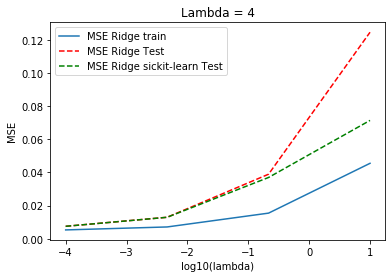

In [255]:
ridgeRegression(X_train, X_test,z_train,n)